In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Load dataset (download from http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip)
# Note: This uses the training dataset (1.6M tweets)
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', 
                 encoding='ISO-8859-1', 
                 header=None,
                 names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Preprocessing functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtag symbol
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Clean text and convert labels
df['text'] = df['text'].apply(clean_text)
df['target'] = df['target'].replace(4, 1)  # Convert 4 to 1 for positive class

# Split dataset
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization and padding
vocab_size = 10000
max_len = 100
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Build LSTM model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Evaluate the model
y_pred = (model.predict(X_test_pad) > 0.5).astype(int)

print("\nEvaluation Metrics:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Print additional metrics
report = classification_report(y_test, y_pred, output_dict=True)
print(f"\nDetailed Metrics:")
print(f"Precision (Positive): {report['1']['precision']:.4f}")
print(f"Recall (Positive): {report['1']['recall']:.4f}")
print(f"F1-Score (Positive): {report['1']['f1-score']:.4f}")
print(f"Precision (Negative): {report['0']['precision']:.4f}")
print(f"Recall (Negative): {report['0']['recall']:.4f}")
print(f"F1-Score (Negative): {report['0']['f1-score']:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1744397408.174984      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744397408.175710      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/5


I0000 00:00:1744397414.254320      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


18000/18000 ━━━━━━━━━━━━━━━━━━━━ 199s 11ms/step - accuracy: 0.4997 - loss: 0.6933 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 2/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 193s 11ms/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.4999 - val_loss: 0.6932
Epoch 3/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 193s 11ms/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.4999 - val_loss: 0.6932
Epoch 4/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 193s 11ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.4999 - val_loss: 0.6932
Epoch 5/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 193s 11ms/step - accuracy: 0.4987 - loss: 0.6932 - val_accuracy: 0.4999 - val_loss: 0.6932
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step

Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67    159494
           1       0.00      0.00      0.00    160506

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
w

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [4]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

# ------------------------------
# Configuration
# ------------------------------
CONFIG = {
    'vocab_size': 20000,
    'embed_dim': 128,
    'lstm_units': 128,
    'dense_units': 64,
    'dropout_rate': 0.5,
    'l2_reg': 0.01,
    'batch_size': 128,
    'epochs': 5,
    'max_seq_len': 150,
    'test_size': 0.2,
    'random_state': 42
}

# ------------------------------
# Load and Preprocess Data
# ------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|@\S+|#\S+', '', text)  # remove URLs, mentions, hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    return text

# Load dataset (Update with actual path if needed)
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df = df[['text', 'target']]

# Convert target to binary (0 = negative, 1 = positive)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# Clean text
df['text'] = df['text'].apply(clean_text)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=CONFIG['vocab_size'])
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=CONFIG['max_seq_len'])
y = df['target'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=CONFIG['test_size'], random_state=CONFIG['random_state'])

# ------------------------------
# LSTM Model Architecture
# ------------------------------
model = Sequential([
    Embedding(
        input_dim=CONFIG['vocab_size'] + 1,
        output_dim=CONFIG['embed_dim'],
        input_length=CONFIG['max_seq_len']
    ),
    LSTM(CONFIG['lstm_units'], kernel_regularizer=l2(CONFIG['l2_reg']), return_sequences=False),
    Dropout(CONFIG['dropout_rate']),
    Dense(CONFIG['dense_units'], activation='relu', kernel_regularizer=l2(CONFIG['l2_reg'])),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# ------------------------------
# Train the Model
# ------------------------------
model.fit(X_train, y_train, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'], validation_split=0.1)

# ------------------------------
# Evaluate the Model
# ------------------------------
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 128s 14ms/step - accuracy: 0.7693 - loss: 0.5714 - val_accuracy: 0.8048 - val_loss: 0.4444
Epoch 2/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - accuracy: 0.8086 - loss: 0.4345 - val_accuracy: 0.8073 - val_loss: 0.4309
Epoch 3/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 126s 14ms/step - accuracy: 0.8162 - loss: 0.4193 - val_accuracy: 0.8139 - val_loss: 0.4215
Epoch 4/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 126s 14ms/step - accuracy: 0.8220 - loss: 0.4081 - val_accuracy: 0.8167 - val_loss: 0.4173
Epoch 5/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - accuracy: 0.8267 - loss: 0.4009 - val_accuracy: 0.8160 - val_loss: 0.4147
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step

Accuracy  : 0.8158
Precision : 0.8153
Recall    : 0.8181
F1 Score  : 0.8167


Epoch 1/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - accuracy: 0.8296 - loss: 0.3959 - val_accuracy: 0.8132 - val_loss: 0.4209
Epoch 2/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - accuracy: 0.8316 - loss: 0.3913 - val_accuracy: 0.8160 - val_loss: 0.4207
Epoch 3/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - accuracy: 0.8332 - loss: 0.3878 - val_accuracy: 0.8167 - val_loss: 0.4226
Epoch 4/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - accuracy: 0.8354 - loss: 0.3850 - val_accuracy: 0.8160 - val_loss: 0.4210
Epoch 5/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - accuracy: 0.8378 - loss: 0.3804 - val_accuracy: 0.8127 - val_loss: 0.4243


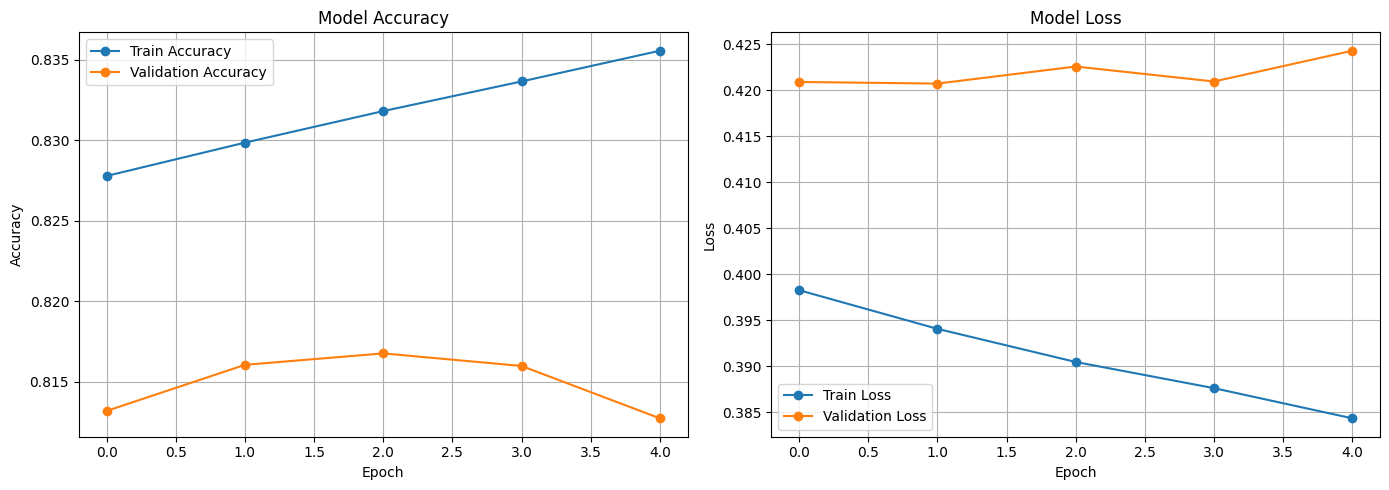

In [5]:
import matplotlib.pyplot as plt

# ------------------------------
# Plot Accuracy and Loss Graphs
# ------------------------------

# Train the model and capture history
history = model.fit(
    X_train, y_train,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    validation_split=0.1
)

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
